# Installation des packages

In [110]:
!pip install pycountry_convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importation des packages



In [111]:
import pandas as pd
import pycountry_convert as pc

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import time

# Fonctions



In [112]:
def split_date(df, date_column):
  """
  Fonction pour séparer une colonne de dates en jours, mois, années et trimestres.

  Paramètres :
  - df (pandas.DataFrame) : le DataFrame contenant la colonne de dates à séparer.
  - date_column (str) : le nom de la colonne de dates à séparer.

  Retourne :
  - pandas.Series : la colonne des jours.
  - pandas.Series : la colonne des mois.
  - pandas.Series : la colonne des années.
  - pandas.Series : la colonne des trimestres.
  """
  return  df[date_column].dt.day, df[date_column].dt.month, df[date_column].dt.year, df[date_column].dt.quarter


def get_continent(iso_code):
  """
  Fonction pour récupérer le continent à partir du code ISO du pays.

  Paramètres :
  - iso_code (str) : le code ISO à deux lettres du pays.

  Retourne :
  - str : le code du continent (AF, AS, EU, NA, OC, SA, AN) si le code ISO du pays est reconnu, "Inconnue" sinon.
  """

  try:
      return pc.country_alpha2_to_continent_code(iso_code)
  except:
      return "Inconnue"

In [113]:
def load_data(predict_var):
  """
    Fonction permettant de charger les données du fichier financement.csv, de nettoyer et de faire du feature engineering

    Paramètres :
    - predict_var (String) : Variable à prédire (etat_int ou promesse_usd2)
  """

  financement_df = pd.read_csv("financement.csv", sep=",", index_col=0) # Lecture du fichier csv
  financement_df = financement_df[~financement_df["etat"].isin(["undefined", "live", "suspended"])] # On exclue les projets avec un état undefined, live ou suspended

  # On ajoute également une colonne etat_int avec une valeur de 0 pour les projets ayant un état failed ou canceled, et 1 pour les projets ayant un état successful
  financement_df["etat_int"] = financement_df["etat"].map({'failed': 0, 'canceled': 0, 'successful': 1})

  if predict_var == "etat_int":
    drop_columns = ["supporters", "objectif", "promesse", "promesse_usd1", "promesse_usd2", "categorie_principale"]  
  else:
    drop_columns = ["supporters", "objectif", "promesse", "promesse_usd1", "categorie_principale"]  

  financement_df.drop(drop_columns, axis=1, inplace=True)


  # On créer des classes pour éviter que les données extrèmes influencent trop notre modèle
  if predict_var == "etat_int":
     num_col = financement_df.drop(["ID", "etat_int"], axis=1).select_dtypes(include=['int', 'float']).columns
  else:
    num_col = financement_df.drop(["ID", "etat_int", "promesse_usd2"], axis=1).select_dtypes(include=['int', 'float']).columns 
    bins = [-1,  10, 100, 500, 1000, 2500, 5000, 10000, max(financement_df["promesse_usd2"])]
    labels = ['-10', '11-100', '101-500', '501-1000', '1001-2500', '2501-5000', '5001-10000', '10001+']
    financement_df["promesse_usd2_cat"] = pd.cut(financement_df["promesse_usd2"], bins=bins, labels=labels)
    financement_df["promesse_usd2_cat_int"] = financement_df["promesse_usd2_cat"].map({'-10': 0, '11-100': 1, '101-500': 2, '501-1000': 3, '1001-2500': 4, '2501-5000': 5, '5001-10000': 6, '10001+': 7}).astype(int)

  if len(num_col) > 0:
    for col in num_col:
      col_stats = financement_df[col].describe()
      bins = [
          col_stats.get("min"), 
          col_stats.get("25%"), 
          col_stats.get("50%"), 
          col_stats.get("75%"), 
          col_stats.get("max"), 
      ]

      labels = ['Très faible', 'Faible', 'Moyen', 'Elevé']
      financement_df[f'{col}_cat'] = pd.cut(financement_df[col], bins=bins, labels=labels)
    
    cat_col = [col for col in financement_df.columns if col.endswith("_cat")]
    financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[cat_col])], axis=1)

  # On convertit les colonnes lancement et date_butoire au format datetime, on calcule la différence entre les deux en jours, et on supprime les projets dont la durée est supérieure à 1000 jours
  financement_df["lancement"] = pd.to_datetime(financement_df["lancement"])
  financement_df["date_butoire"] = pd.to_datetime(financement_df["date_butoire"])
  financement_df['ecart_jours'] = (financement_df['date_butoire'] - financement_df['lancement']).dt.days
  financement_df = financement_df[financement_df["ecart_jours"] < 14000]

  # On utilise la fonction split_date pour séparer les colonnes lancement et date_butoire en jours, mois, années et trimestres
  financement_df["lancement_day"], financement_df["lancement_month"], financement_df["lancement_year"], financement_df["lancement_quarter"] = split_date(financement_df, "lancement")
  financement_df["date_butoire_day"], financement_df["date_butoire_month"], financement_df["date_butoire_year"], financement_df["date_butoire_quarter"] = split_date(financement_df, "date_butoire")

  # On dummifie certaines colonnes
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[["categorie"]])], axis=1)
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["monaie"])], axis=1)
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["pays"])], axis=1)

  # On ajoute une colonne continent en utilisant la fonction get_continent pour récupérer le continent à partir du code ISO du pays, et on supprime les projets avec continent "Inconnue"
  financement_df['continent'] = financement_df['pays'].apply(get_continent)
  financement_df = financement_df[financement_df["continent"] != "Inconnue"]
  financement_df["continent_int"] = financement_df["continent"].map({'NA': 0, 'EU': 1, 'OC': 2, 'AS': 3}) # On ajoute une colonne continent_int avec une valeur numérique pour chaque continent


  return financement_df

In [114]:
# Vous pouvez ajouter des filtres ou des variables dans la fonction load_data()

# Modèle

# Prédiction de la variable etat_int

## Chargement des données

*Ne pas oublier de mettre le fichier financement.csv à la racine*

In [115]:
financement_df = load_data("etat_int")

On crée une liste avec les noms de colonnes que l'on souhaite conserver pour l'entraînement du modèle

Ici nous gardons que les variables avec une corrélation suppérieur à 0.05.
A vous de choisir les colonnes que vous souhaitez conserver pour l'entraînement du modèle

In [116]:
corr_matrix = financement_df.corr()
corr_matrix = corr_matrix["etat_int"].abs().sort_values(ascending=False).reset_index()
corr_matrix = corr_matrix[corr_matrix["etat_int"] > 0.05]

X_columns = corr_matrix["index"].to_list()[1:]

print("Features sélectionnées :", X_columns)

<ipython-input-116-0ec6623694df>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Features sélectionnées : ['objectif_usd_cat_Elevé', 'objectif_usd_cat_Très faible', 'ecart_jours', 'date_butoire_year', 'lancement_year', 'categorie_Tabletop Games', 'categorie_Apps', 'categorie_Theater', 'categorie_Indie Rock', 'categorie_Shorts', 'categorie_Web', 'categorie_Country & Folk', 'US', 'USD', 'categorie_Video Games', 'objectif_usd_cat_Faible', 'EUR', 'categorie_Dance']


In [117]:
print("Features sélectionnées :", X_columns)

Features sélectionnées : ['objectif_usd_cat_Elevé', 'objectif_usd_cat_Très faible', 'ecart_jours', 'date_butoire_year', 'lancement_year', 'categorie_Tabletop Games', 'categorie_Apps', 'categorie_Theater', 'categorie_Indie Rock', 'categorie_Shorts', 'categorie_Web', 'categorie_Country & Folk', 'US', 'USD', 'categorie_Video Games', 'objectif_usd_cat_Faible', 'EUR', 'categorie_Dance']


Vérifions que nos variables choisies ne sont pas corréler entre-elles

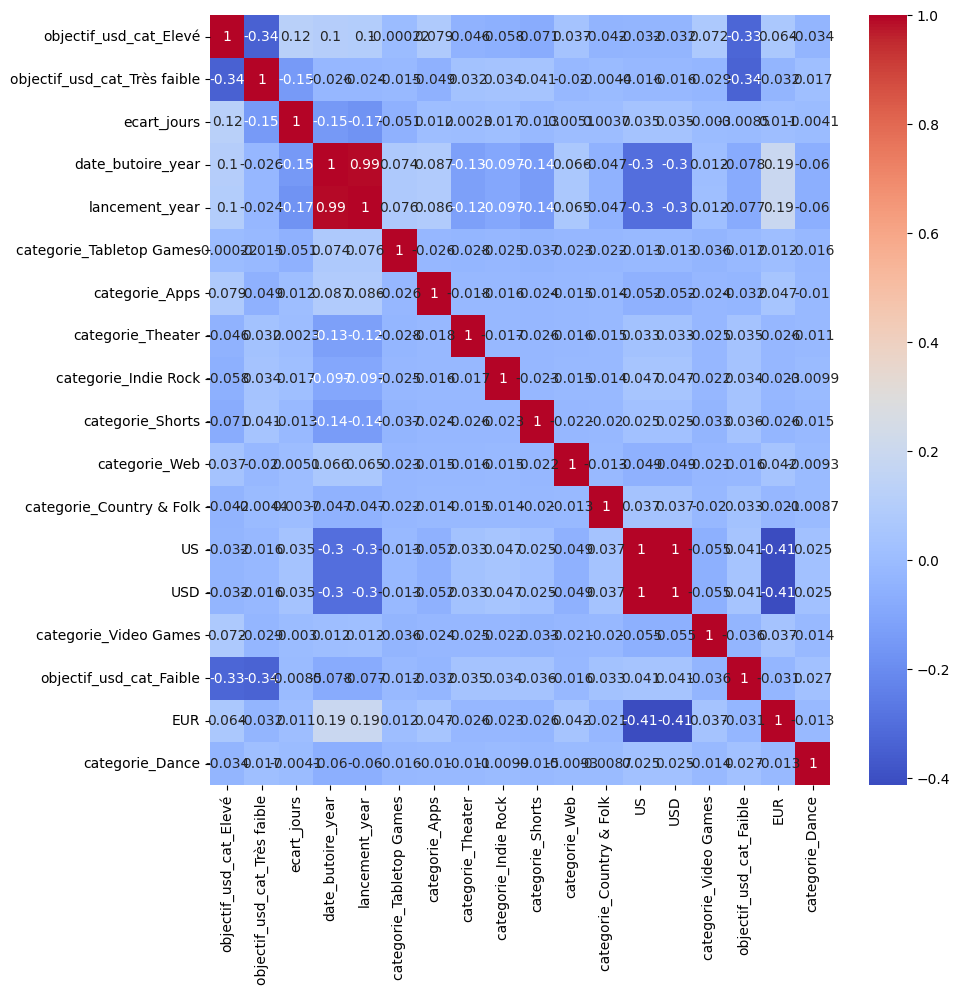

In [118]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(financement_df[X_columns].corr(), annot=True, cmap="coolwarm", ax=ax)
plt.show()

In [119]:
# Initialiser les modèles
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Logistic Regression  + class_weight balanced', LogisticRegression(max_iter=1000, class_weight="balanced")),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Decision Tree  + class_weight balanced', DecisionTreeClassifier(class_weight="balanced")),
    ('Random Forest', RandomForestClassifier()),
    ('Random Forest + class_weight balanced', RandomForestClassifier(class_weight="balanced")),
    ('KNN 10', KNeighborsClassifier(n_neighbors=10)),
    ('KNN 10 + weight distance', KNeighborsClassifier(n_neighbors=10, weights='distance')),
]

X_columns = corr_matrix["index"].to_list()[1:]

# On sépare les features et la variable cible en deux DataFrames X et y
X = financement_df[X_columns]
y = financement_df['etat_int']

# Évalue les modèles en utilisant la validation croisée
results = []
for name, model in models:
    print(f"start of {name}...")
    start_time = time.time()
    cv_scores = cross_val_score(model, X, y, cv=5)
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 2)
    results.append([name, cv_scores.mean(), cv_scores.std(), elapsed_time])
    print(f"end of {name}.")

# Converti les résultats en dataframe et les afficher
results_df = pd.DataFrame(results, columns=['Model', 'Mean CV Score', 'CV Score Std Dev', 'Elapsed Time'])
print(results_df)

start of Logistic Regression...
end of Logistic Regression.
start of Logistic Regression  + class_weight balanced...
end of Logistic Regression  + class_weight balanced.
start of Decision Tree...
end of Decision Tree.
start of Decision Tree  + class_weight balanced...
end of Decision Tree  + class_weight balanced.
start of Random Forest...
end of Random Forest.
start of Random Forest + class_weight balanced...
end of Random Forest + class_weight balanced.
start of KNN 10...
end of KNN 10.
start of KNN 10 + weight distance...
end of KNN 10 + weight distance.
                                          Model  Mean CV Score  \
0                           Logistic Regression       0.665571   
1  Logistic Regression  + class_weight balanced       0.600530   
2                                 Decision Tree       0.674844   
3        Decision Tree  + class_weight balanced       0.646342   
4                                 Random Forest       0.675727   
5         Random Forest + class_weight b

In [120]:
# Créé un graphique Plotly des performances
fig = px.bar(results_df, title="Comparaison de la performance des différents modèles", x='Model', y='Mean CV Score', error_y='CV Score Std Dev', text='Elapsed Time')
fig.update_traces(texttemplate='%{text} s', textposition='outside')
fig.update_layout(width=1200, height=800, title="Comparaison de la performance des différents modèles")
fig.show()

print("\n\n")

Logistic Regression


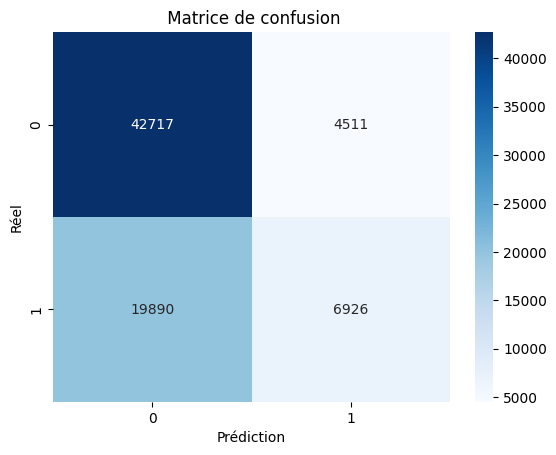

Classification report
              precision    recall  f1-score   support

           0       0.68      0.90      0.78     47228
           1       0.61      0.26      0.36     26816

    accuracy                           0.67     74044
   macro avg       0.64      0.58      0.57     74044
weighted avg       0.65      0.67      0.63     74044




Decision Tree


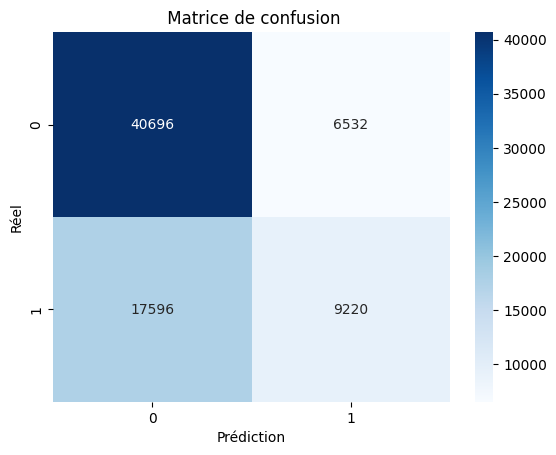

Classification report
              precision    recall  f1-score   support

           0       0.70      0.86      0.77     47228
           1       0.59      0.34      0.43     26816

    accuracy                           0.67     74044
   macro avg       0.64      0.60      0.60     74044
weighted avg       0.66      0.67      0.65     74044




Random Forest


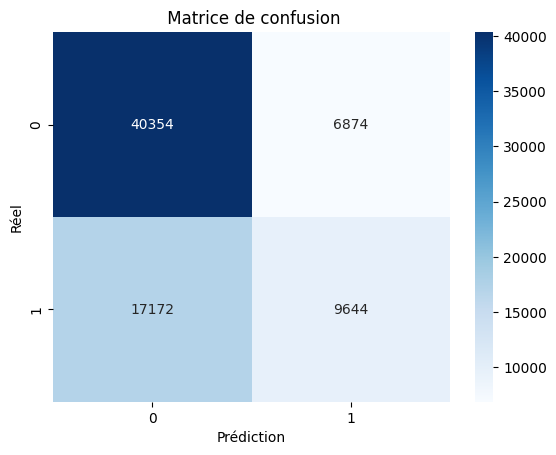

Classification report
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     47228
           1       0.58      0.36      0.45     26816

    accuracy                           0.68     74044
   macro avg       0.64      0.61      0.61     74044
weighted avg       0.66      0.68      0.65     74044




KNN 10


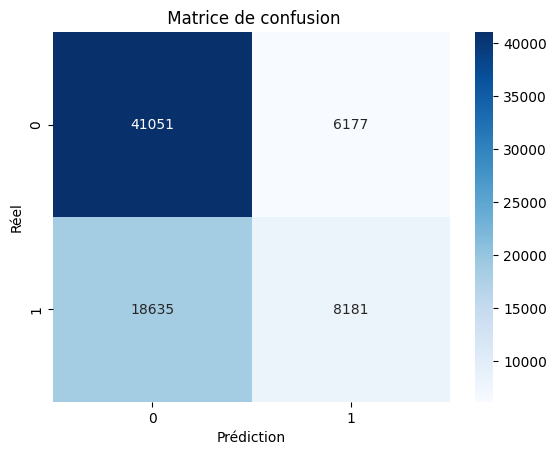

Classification report
              precision    recall  f1-score   support

           0       0.69      0.87      0.77     47228
           1       0.57      0.31      0.40     26816

    accuracy                           0.66     74044
   macro avg       0.63      0.59      0.58     74044
weighted avg       0.65      0.66      0.63     74044






In [121]:
# Initialise les modèles
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN 10', KNeighborsClassifier(n_neighbors=10)),
]

for name, model in models:
  print(name)
  # On sépare les features et la variable cible en deux DataFrames X et y
  X = financement_df[X_columns]
  y = financement_df['etat_int']

  # On utilise la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  # On utilise StandardScaler pour centrer et réduire les données d'entraînement, puis appliquer la même transformation aux données de test
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # On entraîne le modèle sur les données d'entraînement normalisées
  model = model
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test) # On utilise le modèle pour prédire la variable cible y_test à partir des features X_test

  # On calcule la matrice de confusion pour évaluer les performances du modèle
  conf_matrix = confusion_matrix(y_test, y_pred)

  # On affiche la matrice de confusion sous forme de heatmap
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(" Matrice de confusion")
  plt.xlabel("Prédiction")
  plt.ylabel("Réel")
  plt.show()

  class_report = classification_report(y_test, y_pred) # On affiche le classification report pour avoir un aperçu détaillé des performances du modèle par classe.
  print("Classification report")
  print(class_report)
  print("\n\n")

# Prédiction de la variable promesse_usd2

In [123]:
financement_df = load_data("promesse_usd2")

In [132]:
corr_matrix = financement_df.corr()

corr_matrix = corr_matrix["promesse_usd2_cat_int"].abs().sort_values(ascending=False).reset_index()
corr_matrix = corr_matrix[corr_matrix["promesse_usd2_cat_int"] > 0.05]

X_columns = corr_matrix["index"].to_list()[1:]

X_columns = [col for col in X_columns if not col.startswith("promesse")]
print("Features sélectionnées :", X_columns)

<ipython-input-132-85c423e954b7>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Features sélectionnées : ['etat_int', 'objectif_usd_cat_Très faible', 'categorie_Tabletop Games', 'categorie_Product Design', 'objectif_usd_cat_Moyen', 'categorie_Apps', 'categorie_Web', 'objectif_usd_cat_Elevé', 'categorie_Hip-Hop', 'US', 'USD', 'categorie_Fiction', 'date_butoire_year', 'lancement_year', 'categorie_Hardware', 'categorie_Crafts', 'continent_int', 'categorie_Apparel']


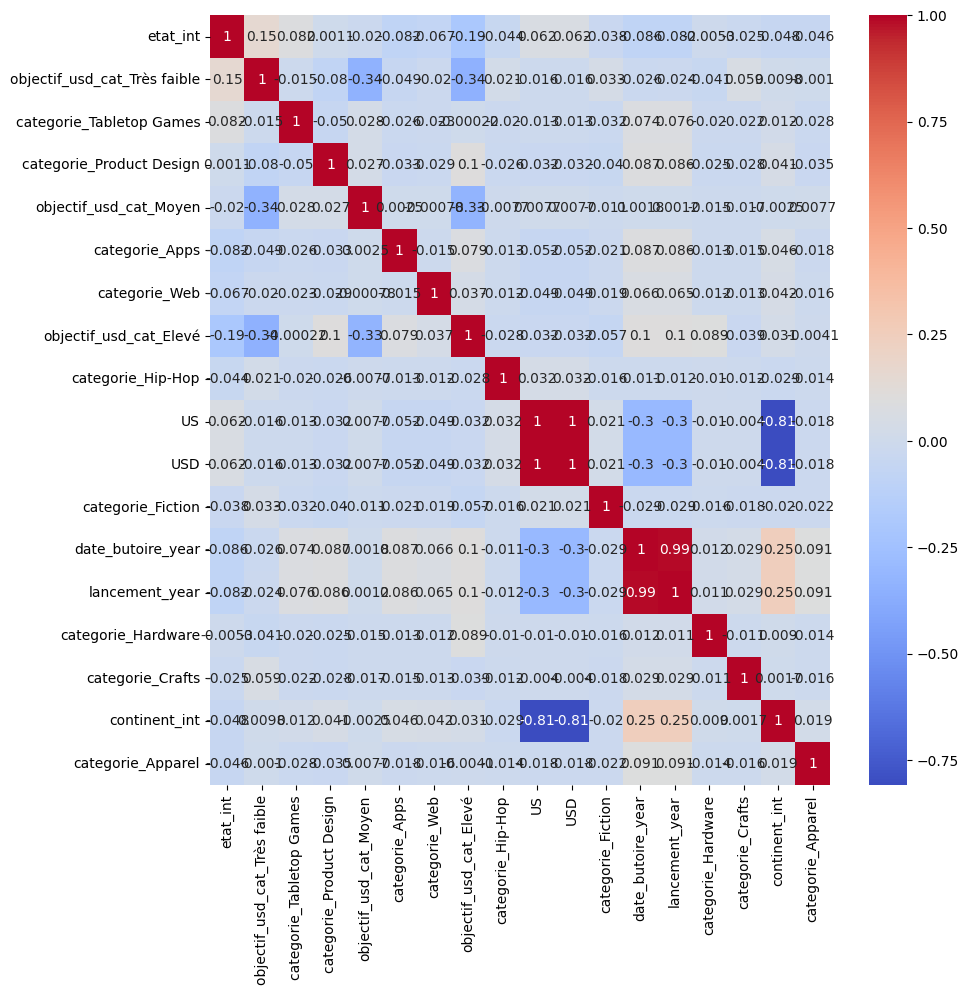

In [133]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(financement_df[X_columns].corr(), annot=True, cmap="coolwarm", ax=ax)
plt.show()

In [134]:
# Initialise les modèles
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Logistic Regression  + class_weight balanced', LogisticRegression(max_iter=1000, class_weight="balanced")),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Decision Tree  + class_weight balanced', DecisionTreeClassifier(class_weight="balanced")),
    ('Random Forest', RandomForestClassifier()),
    ('Random Forest + class_weight balanced', RandomForestClassifier(class_weight="balanced"))
]

# On sépare les features et la variable cible en deux DataFrames X et y
X = financement_df[X_columns]
y = financement_df['promesse_usd2_cat_int']

# Évalue les modèles en utilisant la validation croisée
results = []
for name, model in models:
    print(f"start of {name}...")
    start_time = time.time()
    cv_scores = cross_val_score(model, X, y, cv=5)
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 2)
    results.append([name, cv_scores.mean(), cv_scores.std(), elapsed_time])
    print(f"end of {name}.")

# Converti les résultats en dataframe et les afficher
results_df = pd.DataFrame(results, columns=['Model', 'Mean CV Score', 'CV Score Std Dev', 'Elapsed Time'])

start of Logistic Regression...
end of Logistic Regression.
start of Logistic Regression  + class_weight balanced...
end of Logistic Regression  + class_weight balanced.
start of Decision Tree...
end of Decision Tree.
start of Decision Tree  + class_weight balanced...
end of Decision Tree  + class_weight balanced.
start of Random Forest...
end of Random Forest.
start of Random Forest + class_weight balanced...
end of Random Forest + class_weight balanced.


In [135]:
# Créé un graphique Plotly des performances
fig = px.bar(results_df, title="Comparaison de la performance des différents modèles", x='Model', y='Mean CV Score', error_y='CV Score Std Dev', text='Elapsed Time')
fig.update_traces(texttemplate='%{text} s', textposition='outside')
fig.update_layout(width=1200, height=800, title="Comparaison de la performance des différents modèles")
fig.show()

print("\n\n")

Logistic Regression


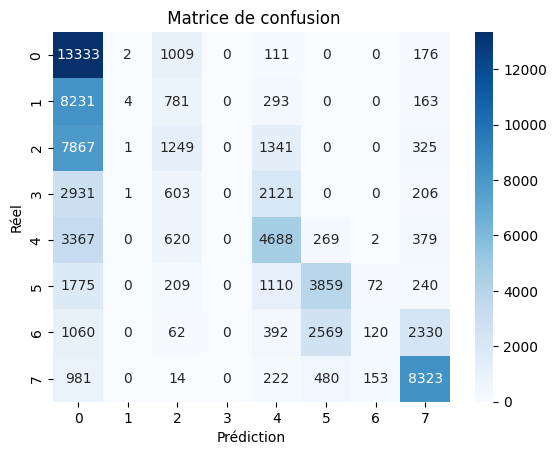

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification report
              precision    recall  f1-score   support

           0       0.34      0.91      0.49     14631
           1       0.50      0.00      0.00      9472
           2       0.27      0.12      0.16     10783
           3       0.00      0.00      0.00      5862
           4       0.46      0.50      0.48      9325
           5       0.54      0.53      0.53      7265
           6       0.35      0.02      0.03      6533
           7       0.69      0.82      0.75     10173

    accuracy                           0.43     74044
   macro avg       0.39      0.36      0.31     74044
weighted avg       0.41      0.43      0.34     74044




Decision Tree


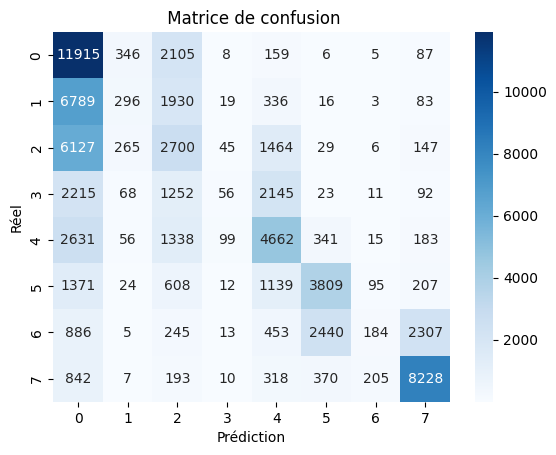

Classification report
              precision    recall  f1-score   support

           0       0.36      0.81      0.50     14631
           1       0.28      0.03      0.06      9472
           2       0.26      0.25      0.26     10783
           3       0.21      0.01      0.02      5862
           4       0.44      0.50      0.47      9325
           5       0.54      0.52      0.53      7265
           6       0.35      0.03      0.05      6533
           7       0.73      0.81      0.77     10173

    accuracy                           0.43     74044
   macro avg       0.40      0.37      0.33     74044
weighted avg       0.40      0.43      0.37     74044




Random Forest


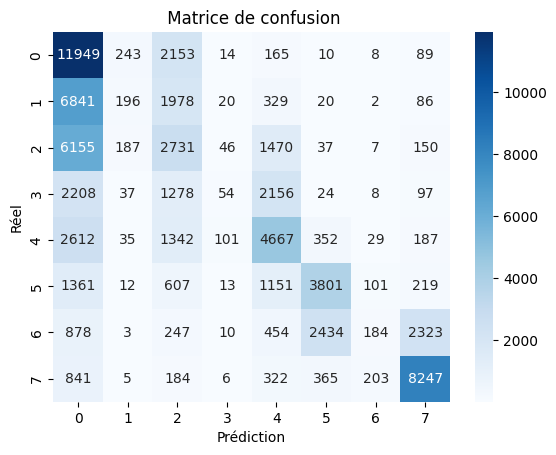

Classification report
              precision    recall  f1-score   support

           0       0.36      0.82      0.50     14631
           1       0.27      0.02      0.04      9472
           2       0.26      0.25      0.26     10783
           3       0.20      0.01      0.02      5862
           4       0.44      0.50      0.47      9325
           5       0.54      0.52      0.53      7265
           6       0.34      0.03      0.05      6533
           7       0.72      0.81      0.76     10173

    accuracy                           0.43     74044
   macro avg       0.39      0.37      0.33     74044
weighted avg       0.40      0.43      0.36     74044






In [136]:
# Initialise les modèles
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier())
]

for name, model in models:
  print(name)
  # On sépare les features et la variable cible en deux DataFrames X et y
  X = financement_df[X_columns]
  y = financement_df['promesse_usd2_cat_int']

  # On utilise la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  # On utilise StandardScaler pour centrer et réduire les données d'entraînement, puis appliquer la même transformation aux données de test
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # On entraîne le modèle sur les données d'entraînement normalisées
  model = model
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test) # On utilise le modèle pour prédire la variable cible y_test à partir des features X_test

  # On calcule la matrice de confusion pour évaluer les performances du modèle
  conf_matrix = confusion_matrix(y_test, y_pred)

  # On affiche la matrice de confusion sous forme de heatmap
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(" Matrice de confusion")
  plt.xlabel("Prédiction")
  plt.ylabel("Réel")
  plt.show()

  class_report = classification_report(y_test, y_pred) # On affiche le classification report pour avoir un aperçu détaillé des performances du modèle par classe.
  print("Classification report")
  print(class_report)
  print("\n\n")